In [1]:
%matplotlib inline
from bigbang.archive import Archive
from bigbang.analysis import repo_loader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

One of the newest features of BigBang is the ability to analyze git info for each project. For now, we mostly just look at commits over time. We can also analyze individual committers to run cohort visualization. 

First, make sure that you've collected git and mail data. For now, we are looking at scipy, but you can analyze any git repo you'd like by loading its info. Below, we load the mail and git data into data tables.



In [2]:
url = "http://mail.python.org/pipermail/scipy-dev/"
arx = Archive(url, archive_dir="../archives")
repo = repo_loader.get_repo("bigbang")
full_info = repo.commit_data
act = arx.data.groupby("Date").size()
act = act.resample("D", how=np.sum)
act = act[act.index.year <= 2014]
act_week = act.resample("W", how=np.sum)

Checking for bigbang at /home/aryan/urap/bigbang/archives/sample_git_repos/bigbang
failed to add a commit because of an encoding error
failed to add a commit because of an encoding error


In [3]:
print((full_info["Parent Commit"]))

2015-03-17 00:03:27    [00f13d97385763b699b52b562fc204d80149098b, 9f6...
2015-03-17 00:03:11    [00f13d97385763b699b52b562fc204d80149098b, a69...
2015-03-16 23:56:02           [847720442d7cab223a6c83f0bd9db37ca28bdfbd]
2015-03-14 20:18:01           [701212ecb79f1b400c2e293d98ff582c750532d0]
2015-03-12 21:51:25           [aef98ed18e82a52ca4dfc593769f99f4618f8edb]
2015-03-10 00:06:20    [a87af8aed3e0e2fb964579b8a7144361d4c19d2f, e57...
2015-03-10 00:01:08    [0547569578a496cf80d153ca9cf2d20849c1736c, 4ba...
2015-03-09 23:52:56           [a87af8aed3e0e2fb964579b8a7144361d4c19d2f]
2015-03-09 23:40:02    [8c450a41c5446db94c0cff7151a8ef2297c43a07, 847...
2015-03-09 23:31:02           [8c450a41c5446db94c0cff7151a8ef2297c43a07]
2015-03-09 23:20:54           [8c450a41c5446db94c0cff7151a8ef2297c43a07]
2015-03-05 22:47:56    [0b47f504de03817db97e0d3556c98f7c252bc0f9, fef...
2015-03-04 05:48:45           [0b47f504de03817db97e0d3556c98f7c252bc0f9]
2015-03-03 06:12:18           [cf1a386f6d912dd90604

The code below graphs the commits per day and commits per week for scipy. As we will see later, consolidating commits into larger time periods allows for smoother graphs. As you can see, the weekly graph is slightly smoother. We will find some more ways to smoothen these lines.

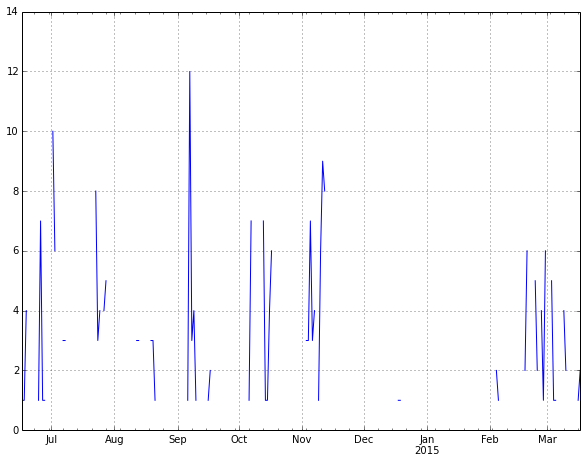

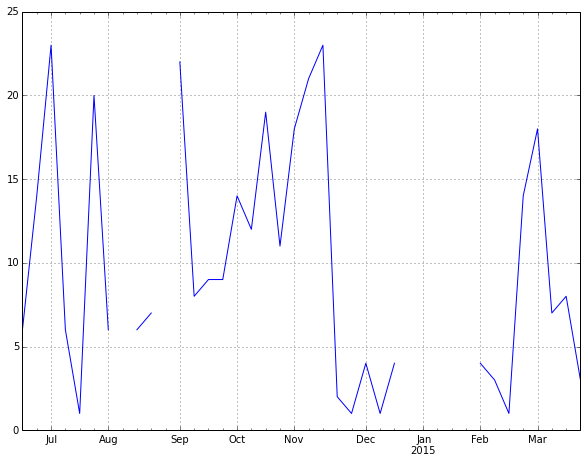

In [4]:
fig = plt.figure(figsize=(10, 7.5))
commits_per_day = repo.commits_per_day()
commits_per_week = repo.commits_per_week()
commits_per_day.plot()
fig = plt.figure(figsize=(10, 7.5))
commits_per_week.plot()

With some convolution, the two jutted graphs make much more sense. This graphs commits per week and emails per week. The fact that we have the git and mail data for the same project lets us analyze the relationship between emails and commits. We can look at whether or not weeks where there is a lot of emailing are followed by weeks of many commits. We can even go down to the individual level and analyze each commiter/emailer with questions like "Is a person less likely to commit if they email a lot?"

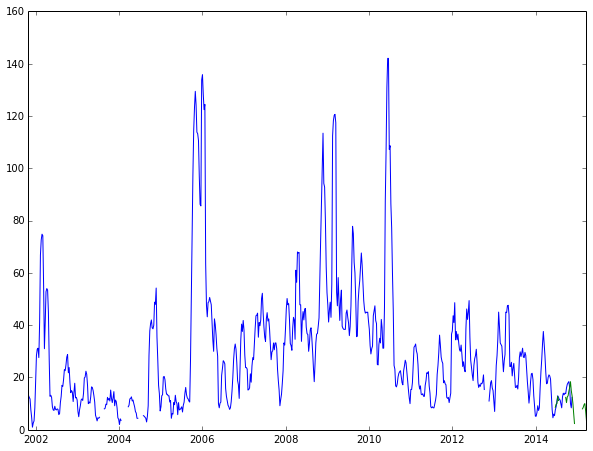

In [5]:
fig = plt.figure(figsize=(10, 7.5))
simp = 5

convulation_array = [1.0 / (simp) for n in range(simp)]
c_array = np.convolve(commits_per_week, convulation_array, "same")
e_array = np.convolve(act_week, convulation_array, "same")
plt.plot(act_week.index, e_array)  # The Blue
plt.plot(commits_per_week.index, c_array)  # The Green

fig.axes[0].xaxis_date()

This is the top 20 (or fewer) committers to a project. An interesting question to answer for the future would be whether or not these committers are more likely to be in the same cohort. 

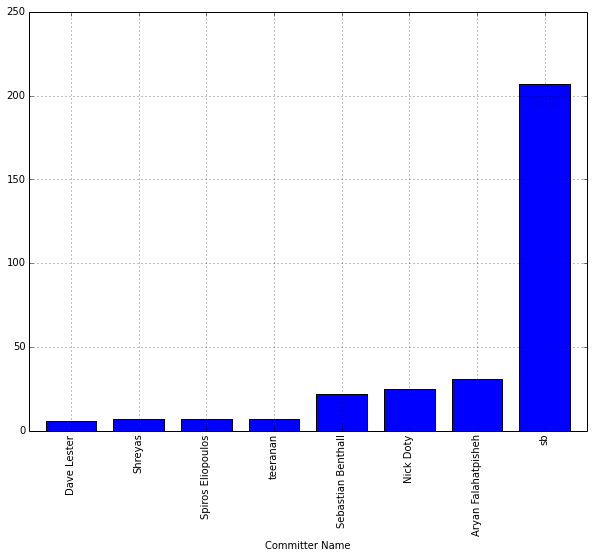

In [6]:
plt.figure(figsize=(10, 7.5))
df = repo.by_committer()
if len(df > 20):
    df = df[len(df) - 20 :]
df.plot(kind="bar")

Below, one can see cohort visualization of commits. Each cohort is a group of commiters that started working on the project around the same time. The first cohort is the first 1/5th of people to start committing, the second cohort is the second 1/5th of people to start committing, and so on. For Scipy, the first cohort of commiters tends to dominate, while the second has recently taken some more charge.

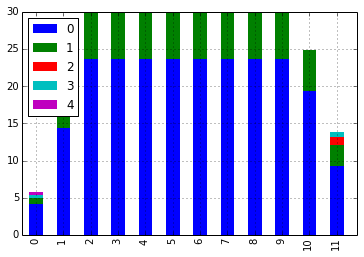

In [7]:
n = 5

import numpy as np


def first_commit_fn(df):
    if len(df) < 1:
        return
    else:
        return df


dataFrame = full_info

commits_by_time = dataFrame.groupby(
    ["Committer Name", dataFrame["Time"].map(lambda x: x.toordinal() / 100)], sort=True
).size()
time = (
    dataFrame.groupby(dataFrame["Time"].map(lambda x: x.toordinal() / 100))
    .size()
    .order()
)
first_commits = dataFrame.groupby("Committer Name").min().sort("Time")
commits_by_time = commits_by_time.reindex(
    index=time.index.values, level=1, fill_value=0
)

cohorts = np.array_split(first_commits, n)
convulation_array = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
cohort_activity = [
    (commits_by_time.loc[cohort.index.values].sum(None, False, 1, False)).reindex(
        index=time.index.values
    )
    for cohort in cohorts
]
for i in range(len(cohort_activity)):
    cohort_activity[i] = np.convolve(cohort_activity[i], convulation_array)


to_graph = pd.DataFrame(cohort_activity).transpose()

to_graph.plot(kind="bar", stacked=True, linewidth=0)

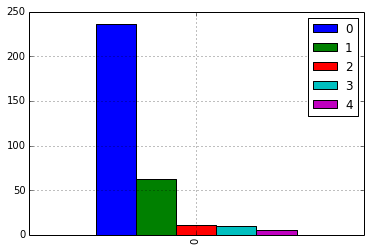

In [8]:
byCommitter = repo.by_committer()
totalCohortCommits = []
for cohort in cohorts:
    cohortPeople = byCommitter.reindex(cohort.index)
    totalCohortCommits.append(cohortPeople.sum())

commitsPerCohort = pd.DataFrame(totalCohortCommits)
commitsPerCohort.transpose().plot(kind="bar")

This explains why the first cohort dominates all the others: those who joined the project early on happen to make many more commits than those who joined later. Part of this is because they've had more time to contribute to the project, but there could be other factors.